In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.stats as ss # statistical functions
import matplotlib.pyplot as plt # plotting
import seaborn as sns # pretty plots
import math
import warnings

from collections import Counter
from sklearn.model_selection import train_test_split # data splitting

import tensorflow as tf  # building NN model
from tensorflow.keras.layers.experimental import preprocessing # input preprocessing

# model evaluation metrics
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score,confusion_matrix

warnings.filterwarnings('ignore')


In [2]:
print(tf.__version__)

2.4.1



### **Pishing** refers to a malicious attempt to acquire a user's personal data by using deceptive emails or webpages.
### The objective of this notebook is to use machine learning to filter out such pishing webpages from the legitimate ones.

#### **This notebook includes the following**

##### 1. Analysis of the features included in the dataset
##### 2. Development of an MLP to determine the legitimacy of a webpage
##### 3. Evaluation of the developed model

In [3]:
# load the data
data = pd.read_csv("/kaggle/input/phishing-dataset-for-machine-learning/Phishing_Legitimate_full.csv")

In [4]:
# list of features
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  10000 non-null  int64  
 1   NumDots                             10000 non-null  int64  
 2   SubdomainLevel                      10000 non-null  int64  
 3   PathLevel                           10000 non-null  int64  
 4   UrlLength                           10000 non-null  int64  
 5   NumDash                             10000 non-null  int64  
 6   NumDashInHostname                   10000 non-null  int64  
 7   AtSymbol                            10000 non-null  int64  
 8   TildeSymbol                         10000 non-null  int64  
 9   NumUnderscore                       10000 non-null  int64  
 10  NumPercent                          10000 non-null  int64  
 11  NumQueryComponents                  10000 



### **Feature Analysis**
#### In the following section, we will separate the categorical and numerical features and analyse them separately

In [5]:
# separate the target variable
label = data.pop('CLASS_LABEL')
ids   = data.pop('id')

# list of categorical features
categorical_features = [
    'AtSymbol','TildeSymbol','NoHttps','RandomString','IpAddress','DomainInSubdomains','DomainInPaths',
    'HttpsInHostname','DoubleSlashInPath','EmbeddedBrandName','ExtFavicon','InsecureForms','RelativeFormAction',
    'ExtFormAction','AbnormalFormAction','FrequentDomainNameMismatch','FakeLinkInStatusBar','RightClickDisabled',
    'PopUpWindow','SubmitInfoToEmail','IframeOrFrame','MissingTitle','ImagesOnlyInForm','SubdomainLevelRT',
    'UrlLengthRT','PctExtResourceUrlsRT','AbnormalExtFormActionR','ExtMetaScriptLinkRT','PctExtNullSelfRedirectHyperlinksRT'
]

# list of numerical features
numerical_features = [x for x in data.columns if x not in categorical_features]


In [7]:
print("Number of Categorical(Nominal) Features : ",len(categorical_features))
print("Number of Numerical(Ordinal) Features : ",len(numerical_features))

Number of Categorical(Nominal) Features :  29
Number of Numerical(Ordinal) Features :  19


In [8]:
categorical_data = data[categorical_features]

# change the datatype to categorical for all columns
for feature in categorical_data.columns:
    categorical_data[feature] = categorical_data[feature].astype('category')
    
# summary statistics for categorical features
categorical_data.describe()


,AtSymbol,TildeSymbol,NoHttps,RandomString,IpAddress,DomainInSubdomains,DomainInPaths,HttpsInHostname,DoubleSlashInPath,EmbeddedBrandName,...,SubmitInfoToEmail,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT
count,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
unique,2,2,2,2,2,2,2,1,2,2,...,2,2,2,2,3,3,3,3,3,3
top,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,1,1,1,1,0,1
freq,9997,9869,9888,5252,9828,9778,5711,10000,9991,9429,...,8712,6604,9678,9696,9666,3465,6341,8469,3988,6094




### **Checking Correlation of categorical features with the target variable**

#### The Uncertainity Coefficient (Theil's U) which represents the following relation between two nominal random variables X and Y, given X how well can we predict Y.



In [9]:
def conditional_entropy(x,y):
    """
    Calculates the conditional entropy of two random varibales X and Y
    wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy
    """
    
    y_counter  = Counter(y) # count of all possible y's (the differnt values that the feature can take and their frequency)
    xy_counter = Counter(list(zip(x,y))) # count of all possible pairs of x and y
    
    total_occurences = sum(y_counter.values())
    entropy = 0.0
    
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy]/total_occurences
        p_y  = y_counter[xy[1]]/total_occurences
        entropy += p_xy*math.log(p_y/p_xy,math.e)
    
    return entropy

In [10]:
def theils_u(x,y):
    """
    Calculates the Theil's Uncertainity Coefficient between two random variables X and Y
    wikipedia: https://en.wikipedia.org/wiki/Uncertainty_coefficient
    """
    
    h_xy = conditional_entropy(x,y) # condtitonal entropy of X and Y
    x_counter = Counter(x) # count of all possible values of X
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n / total_occurrences, x_counter.values())) # probability distribution of X
    h_x = ss.entropy(p_x)
    if h_x == 0:
        return 1
    else:
        return (h_x - h_xy) / h_x
    

In [11]:
# calculating the coefficient of correlation between `label` and all the categorical features

uc_scores = dict()

for feature in categorical_features:
    y  = categorical_data[feature]
    uc = theils_u(label,y)
    uc_scores[feature] = uc
    
# sort the scores in descending order
uc_scores = sorted(uc_scores.items(),key=lambda kv: (kv[1],kv[0]),reverse=True)
for k,v in uc_scores:
    print("{} : {}".format(k,v))
    

PctExtNullSelfRedirectHyperlinksRT : 0.30640684532617585
FrequentDomainNameMismatch : 0.18104492423293908
ExtMetaScriptLinkRT : 0.16957923020651786
SubmitInfoToEmail : 0.1125679667056817
InsecureForms : 0.07946502625455433
PctExtResourceUrlsRT : 0.040843553824205354
IframeOrFrame : 0.04047475571797762
AbnormalExtFormActionR : 0.026208142124493995
UrlLengthRT : 0.021840281668367986
IpAddress : 0.0174171493137134
AbnormalFormAction : 0.016142805575150146
EmbeddedBrandName : 0.015382133840065811
MissingTitle : 0.010609090692902206
DomainInPaths : 0.010103889912071663
ExtFormAction : 0.008099211801888878
DomainInSubdomains : 0.007931099697501191
TildeSymbol : 0.007737063288187011
SubdomainLevelRT : 0.0064973854391998515
RandomString : 0.005256076816576079
RelativeFormAction : 0.0049335643680913305
RightClickDisabled : 0.004362782255926228
PopUpWindow : 0.004211754857410474
NoHttps : 0.0041187624630195365
ExtFavicon : 0.0034599137633324387
DoubleSlashInPath : 0.0004474212774166851
AtSymbol 


### The categorical features with the highest correlation with target variable are

#### '**PctExtNullSelfRedirectHyperlinksRT**', '**FrequentDomainNameMismatch**', '**ExtMetaScriptLinkRT**', '**SubmitInfoToEmail**'

In [12]:
# filter the above features
filtered_cats = ['PctExtNullSelfRedirectHyperlinksRT','ExtMetaScriptLinkRT','FrequentDomainNameMismatch','SubmitInfoToEmail']
filtered_cat_data = categorical_data[filtered_cats]

# revert the datatype to int32
for feature in filtered_cat_data.columns:
    filtered_cat_data[feature] = filtered_cat_data[feature].astype('int32')     

# sample
filtered_cat_data.head()

,PctExtNullSelfRedirectHyperlinksRT,ExtMetaScriptLinkRT,FrequentDomainNameMismatch,SubmitInfoToEmail
0,1,-1,0,0
1,1,1,0,0
2,0,-1,0,0
3,-1,1,1,1
4,-1,-1,1,0


In [14]:
# analysis of numerical features

numerical_data = data[numerical_features]

# summary statistics for numerical features
numerical_data.describe()

,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,NumUnderscore,NumPercent,NumQueryComponents,NumAmpersand,NumHash,NumNumericChars,HostnameLength,PathLength,QueryLength,NumSensitiveWords,PctExtHyperlinks,PctExtResourceUrls,PctNullSelfRedirectHyperlinks
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2.445100,0.586800,3.300300,70.264100,1.818000,0.138900,0.32320,0.073800,0.458600,0.277200,0.002300,5.810300,18.82430,35.564900,8.606500,0.109300,0.241334,0.392932,0.136136
std,1.346836,0.751214,1.863241,33.369877,3.106258,0.545744,1.11466,0.622248,1.344793,1.117356,0.047906,9.617877,8.11654,24.588502,24.313053,0.368737,0.342370,0.387292,0.312413
min,1.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,4.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,2.000000,48.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,14.00000,18.000000,0.000000,0.000000,0.000000,0.030303,0.000000
50%,2.000000,1.000000,3.000000,62.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.000000,18.00000,30.000000,0.000000,0.000000,0.071429,0.247511,0.000000
75%,3.000000,1.000000,4.000000,84.000000,2.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,8.000000,22.00000,48.000000,0.000000,0.000000,0.315874,0.785714,0.047619
max,21.000000,14.000000,18.000000,253.000000,55.000000,9.000000,18.00000,19.000000,23.000000,22.000000,1.000000,111.000000,137.00000,161.000000,188.000000,3.000000,1.000000,1.000000,1.000000


### **Checking Correlation of numerical features with the target variable**

#### The Point Biserial Correlation Coefficient measures the correlation between a dichotomous variable Y and a continous variable X.


In [15]:
# calculate point biserial coefficient between numerical features and the target variable

rpb_scores = dict()

for feature in numerical_features:
    y = numerical_data[feature]
    rpb = abs(ss.pointbiserialr(y,label).correlation)
    rpb_scores[feature] = rpb
    
# sort the scores in descending order
rpb_scores = sorted(rpb_scores.items(),key=lambda kv: (kv[1],kv[0]),reverse=True)
for k,v in rpb_scores:
    print("{} : {}".format(k,v))
    
    

NumDash : 0.37223491648822243
PctNullSelfRedirectHyperlinks : 0.34280619253503297
NumDots : 0.2941113745741385
PctExtHyperlinks : 0.25972792319002624
NumSensitiveWords : 0.25520807467651013
PathLevel : 0.22945038959688044
HostnameLength : 0.1691568937417125
NumDashInHostname : 0.15044434207453125
NumQueryComponents : 0.1473907013329155
NumUnderscore : 0.09886920740580152
NumAmpersand : 0.08144631548410983
QueryLength : 0.0805245582508595
PathLength : 0.07612474993254581
UrlLength : 0.07449306083766773
NumPercent : 0.06846489880098748
NumHash : 0.04801356261566736
SubdomainLevel : 0.04313235403645216
PctExtResourceUrls : 0.021922159435337943
NumNumericChars : 0.01912159923106215



### The numerical features with the highest correlation with target varibale are

#### '**NumDash**', '**PctNullSelfRedirectHyperlinks**', '**NumDots**', '**PctExtHyperlinks**', '**NumSenstiveWords**', '**PathLevel**', '**HostnameLength**', '**NumDashInHostname**', '**NumQueryComponents**'

In [16]:
# filter the above features
filtered_nums = ['NumDash', 'PctNullSelfRedirectHyperlinks', 'NumDots', 'PctExtHyperlinks', 'NumSensitiveWords', 'PathLevel', 'HostnameLength', 'NumDashInHostname', 'NumQueryComponents']
filtered_num_data = data[filtered_nums]



In [17]:
# merge the filtered categorical and numerical data
filtered_data = pd.concat([filtered_num_data,filtered_cat_data],axis=1)
filtered_data['label'] = label

In [18]:
filtered_data.head()

,NumDash,PctNullSelfRedirectHyperlinks,NumDots,PctExtHyperlinks,NumSensitiveWords,PathLevel,HostnameLength,NumDashInHostname,NumQueryComponents,PctExtNullSelfRedirectHyperlinksRT,ExtMetaScriptLinkRT,FrequentDomainNameMismatch,SubmitInfoToEmail,label
0,0,0.0,3,0.000,0,5,21,0,0,1,-1,0,0,1
1,0,0.0,3,0.000,1,3,17,0,2,1,1,0,0,1
2,0,0.0,3,0.375,0,2,27,0,0,0,-1,0,0,1
3,1,0.0,3,1.000,0,6,22,0,0,-1,1,1,1,1
4,0,0.0,3,1.000,0,4,10,0,0,-1,-1,1,0,1





## **Model Creation**

In [19]:
# splitting the data into train,test and validation
train, test = train_test_split(filtered_data, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')



6400 train examples
1600 validation examples
2000 test examples


In [20]:
def dataframe_to_dataset(dataframe, shuffle=True, batch_size=32):
    """
    Creates a tensorflow Dataset object from a Pandas Dataframe
    """
    df = dataframe.copy()
    labels = df.pop('label') # target varibale
    ds = tf.data.Dataset.from_tensor_slices((dict(df),labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds


In [21]:

# creating datasets
batch_size = 256
train_ds = dataframe_to_dataset(train, batch_size=batch_size)
val_ds = dataframe_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = dataframe_to_dataset(test, shuffle=False, batch_size=batch_size)

In [22]:
# preprocessing layer generators

# normalization layer for numerical features
def get_normalization_layer(feature,dataset):
    normalizer = preprocessing.Normalization(axis=None)
    feature_ds = dataset.map(lambda x, y: x[feature])
    normalizer.adapt(feature_ds)
    return normalizer

# encoding layer for categorical features to convert class to onehot encodings
def get_encoding_layer(feature,dataset,dtype,max_tokens):
    index = preprocessing.IntegerLookup(max_values=max_tokens,oov_value=-2)
    feature_ds = dataset.map(lambda x,y : x[feature])
    index.adapt(feature_ds)
    encoder = preprocessing.CategoryEncoding(max_tokens = len(index.get_vocabulary()))
    
    return lambda feature : encoder(index(feature))
    

In [23]:
## model preprocessing layers

all_inputs = list()
encoded_features = list()

# add input layers for the numerical features
for header in filtered_nums:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    normalized_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(normalized_numeric_col)
    
# add input layers for the categorical features
for header in filtered_cats:
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int32')
    encoding_layer = get_encoding_layer(header, train_ds, dtype='int32',max_tokens=5)
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)



In [24]:
# model layers

all_features = tf.keras.layers.concatenate(encoded_features)

x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])


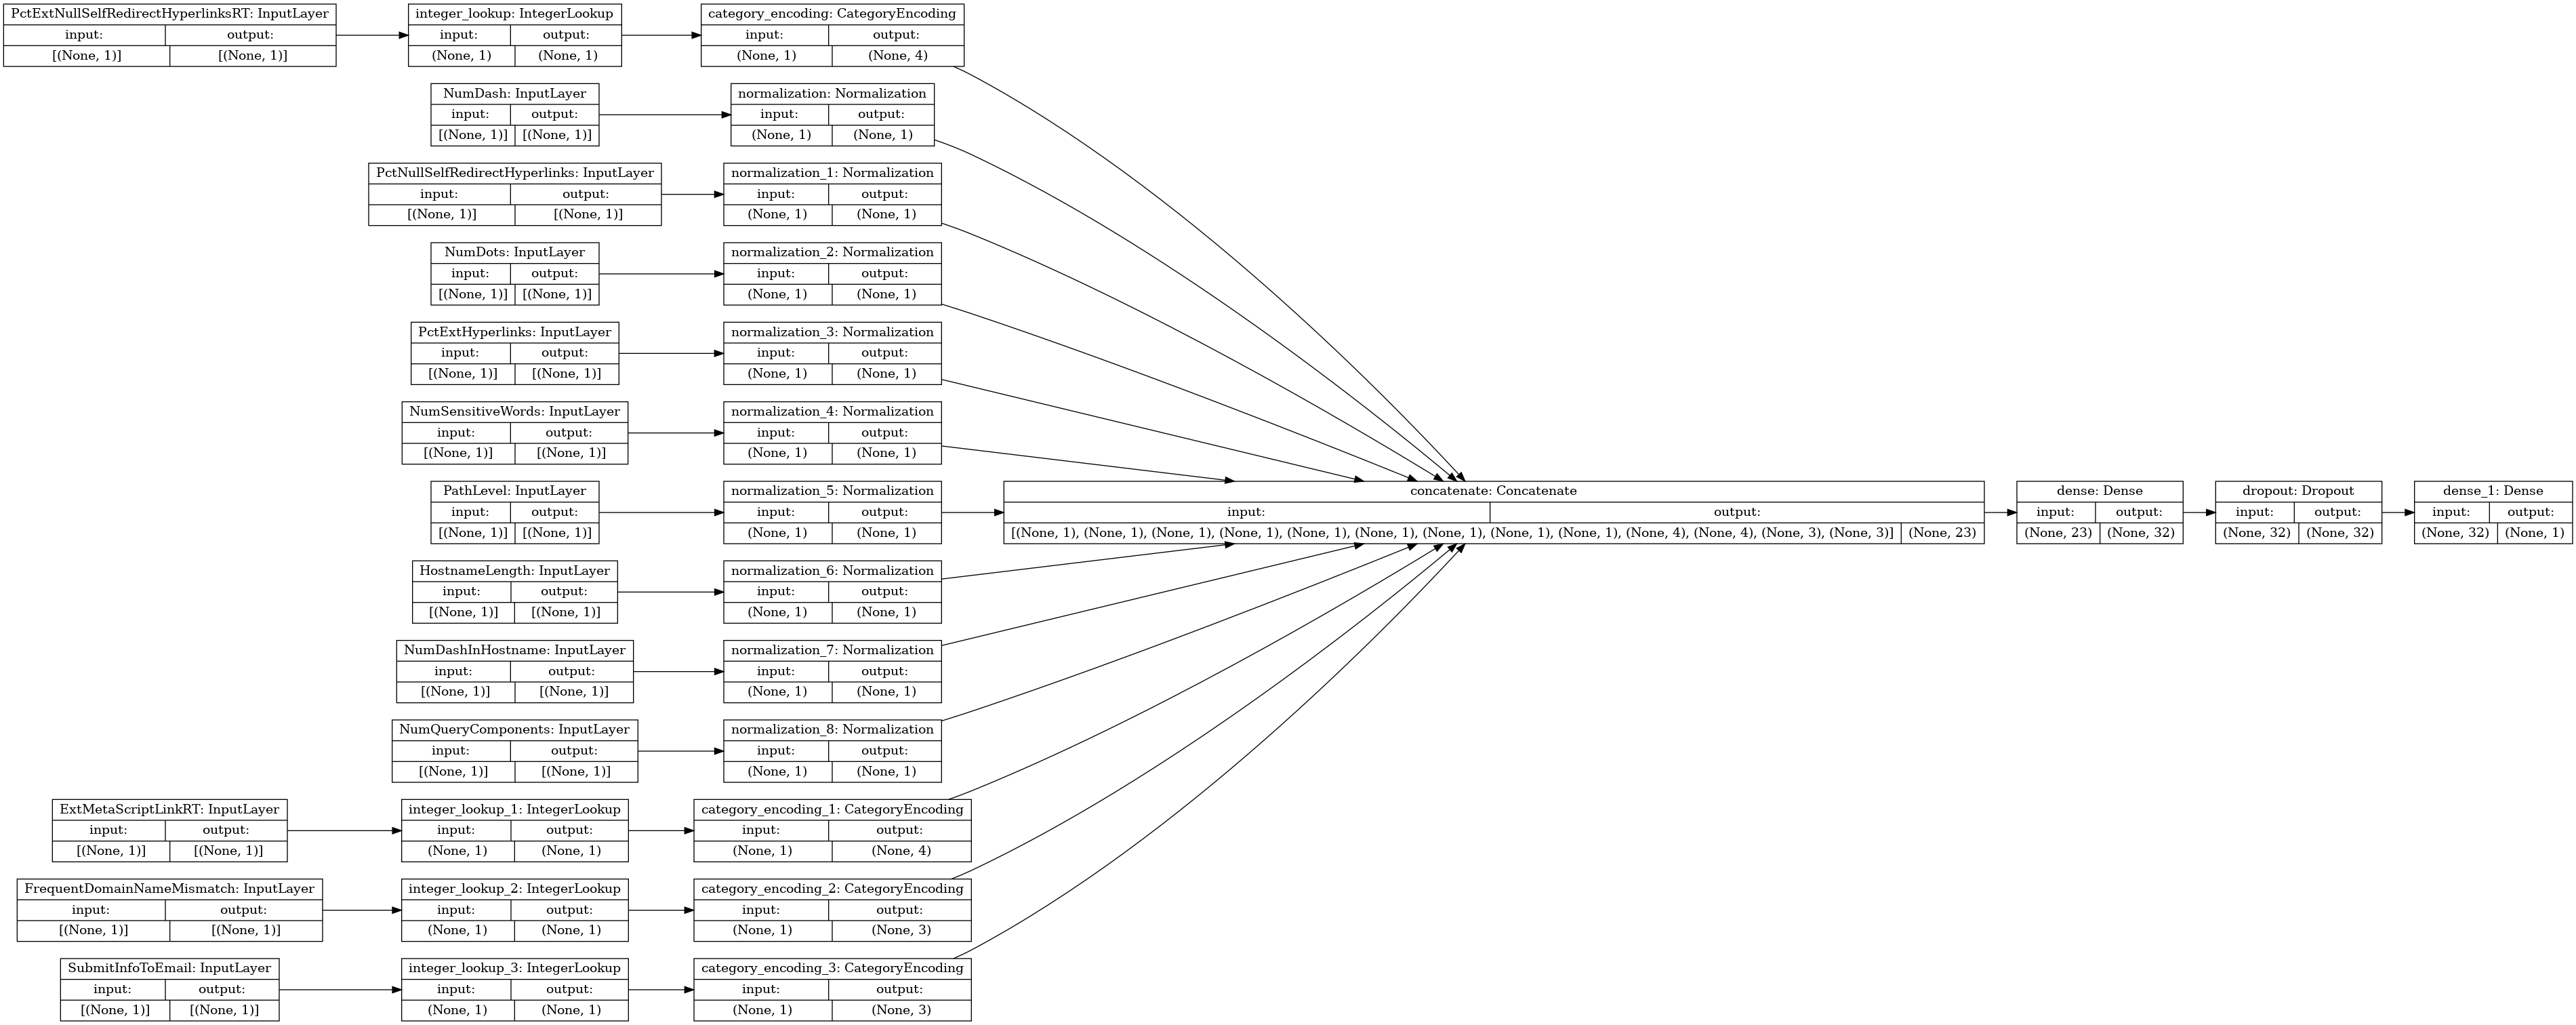

In [25]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")







## **Model Evaluation**

In [26]:
history = model.fit(train_ds, epochs=500, validation_data=val_ds)

Epoch 1/500
25/25 [==============================] - 2s 24ms/step - loss: 0.7575 - accuracy: 0.5196 - val_loss: 0.6171 - val_accuracy: 0.5444
Epoch 2/500
25/25 [==============================] - 0s 5ms/step - loss: 0.6060 - accuracy: 0.5972 - val_loss: 0.5055 - val_accuracy: 0.6875
Epoch 3/500
25/25 [==============================] - 0s 6ms/step - loss: 0.5074 - accuracy: 0.7020 - val_loss: 0.4177 - val_accuracy: 0.8037
Epoch 4/500
25/25 [==============================] - 0s 6ms/step - loss: 0.4227 - accuracy: 0.7790 - val_loss: 0.3547 - val_accuracy: 0.8444
Epoch 5/500
25/25 [==============================] - 0s 5ms/step - loss: 0.3716 - accuracy: 0.8235 - val_loss: 0.3145 - val_accuracy: 0.8637
Epoch 6/500
25/25 [==============================] - 0s 5ms/step - loss: 0.3353 - accuracy: 0.8372 - val_loss: 0.2897 - val_accuracy: 0.8806
Epoch 7/500
25/25 [==============================] - 0s 6ms/step - loss: 0.3097 - accuracy: 0.8577 - val_loss: 0.2728 - val_accuracy: 0.8825
Epoch 8/500


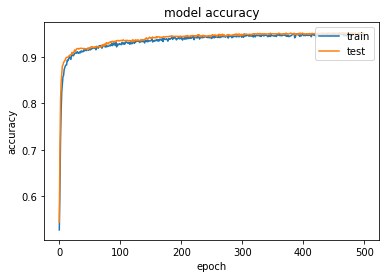

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

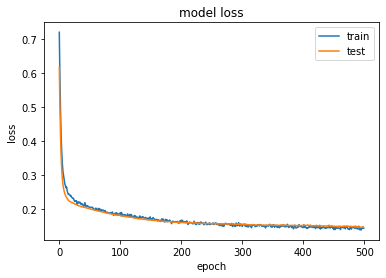

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [29]:
# evaluation on test data
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)


8/8 [==============================] - 0s 2ms/step - loss: 0.1345 - accuracy: 0.9565
Accuracy 0.9564999938011169


### **Evaluation Metrics**

In [30]:
testy = test['label']
y_pred = model.predict(test_ds)
yhat_classes = []
for pred in y_pred:
    if pred > 0:
        yhat_classes.append(1)
    else:
        yhat_classes.append(0)
        

In [31]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testy, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testy, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testy, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testy, yhat_classes)
print('F1 score: %f' % f1)

print("Confusion Matrix : ")
matrix = confusion_matrix(testy, yhat_classes)
print(matrix)

Accuracy: 0.955500
Precision: 0.952930
Recall: 0.961240
F1 score: 0.957067
Confusion Matrix : 
[[919  49]
 [ 40 992]]
